# Chapter 3 Part 3 Exercises

In [84]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import parallel_coordinates
from scipy import stats
import arviz as az
import pymc3 as pm
from IPython.display import SVG, display

In [85]:
az.style.use('arviz-darkgrid')

## Question 11
***

Below are all four datasets from Anscombe's Quartet  
![title](images/640px-Anscombe.png)

A model that might fit the first three models is a polynomial regression of form

$ y = \alpha_2  x^2 + \alpha_1 x + \alpha_0 $

For the more linear datasets the model could have a low value for $\alpha_2$, and for the second dataset the model would be able to fit the non linearity.

For the last dataset there seems to be two distinct patterns, a cluster of points at x=8 and one at x=19. We could model this one with two groups as follows

In [86]:
df = pd.read_csv(os.path.join("..", "code", "data", "anscombe.csv"))
df = df.loc[df["group"] == "IV", ["x", "y"]]

In [87]:
idx = (df["x"] == 8).astype(int)
idx

33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    0
41    1
42    1
43    1
Name: x, dtype: int64

In [88]:
with pm.Model() as anscombe:
    
    # Two groups of points with independent parameters
    sd = pm.HalfNormal("sd", sd=10)
    mu = pm.Normal("mu", shape=2, sd=10)
    
    y = pm.Normal("y", mu=mu[idx], sd=sd, observed=df["y"].values)
    trace_4 = pm.sample(draws=10000)
    ppc = pm.sample_posterior_predictive(trace_4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sd]
100%|██████████| 20000/20000 [00:14<00:00, 1425.09it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1fe04ba8>,
      dtype=object)

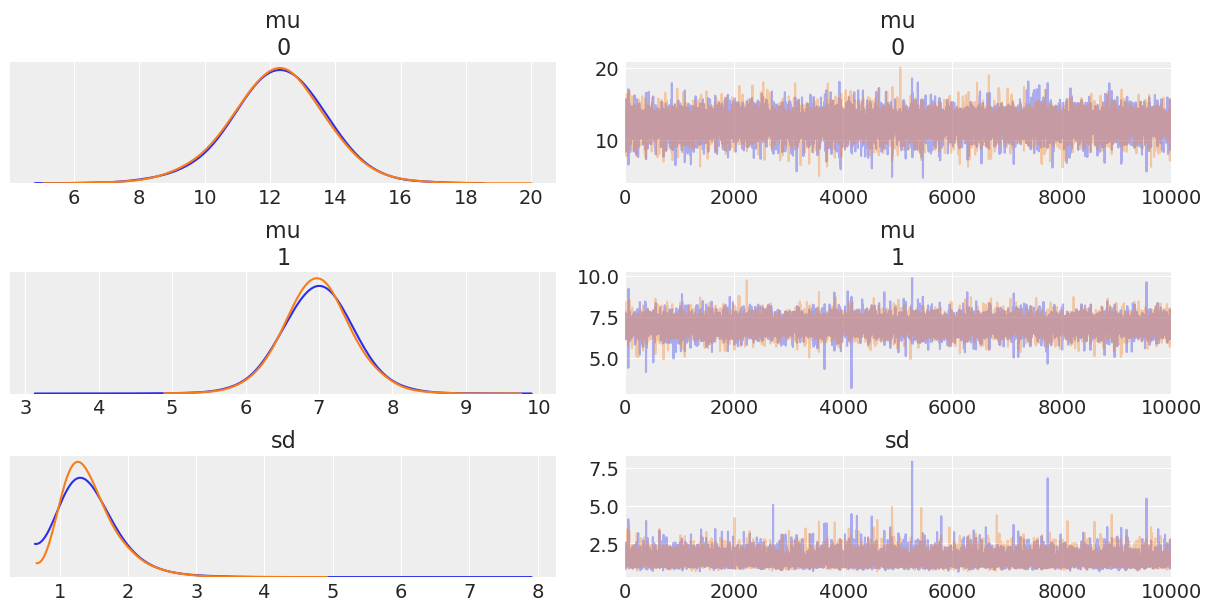

In [89]:
az.plot_trace(trace_4)

# Question 12
***

Which model is model t2?

# Question 13
***

In [90]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real
x_centered = x_m - x_m.mean()

Let's loop through a couple standard deviation values for the slope parameter of each group

In [91]:
sd_values = [1, 10, 100]
all_traces = {}

for sd_value in sd_values:
    with pm.Model() as unpooled_model:
        α_tmp = pm.Normal('α_tmp', mu=0, sd=10, shape=M)
        β = pm.Normal('β', mu=0, sd=sd_value, shape=M)
        
        ϵ = pm.HalfCauchy('ϵ', 5)
        ν = pm.Exponential('ν', 1/30)

        y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                             sd=ϵ, nu=ν, observed=y_m)

        α = pm.Deterministic('α', α_tmp - β * x_m.mean())

        unpooled_model_trace = pm.sample(2000)
        all_traces[sd_value] = unpooled_model_trace

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:25<00:00, 197.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:19<00:00, 262.60draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:20<00:00, 239.42draws/s]


In [92]:
all_traces[10]

<MultiTrace: 2 chains, 2000 iterations, 7 variables>

In [93]:
all_summaries = []
for sd, trace in all_traces.items():
    summary = az.summary(az.from_pymc3(trace=trace))
    summary["group"] =  f"sd_{sd}"
    summary.reset_index(inplace=True)
    #summary. = summary.index +
    all_summaries.append(summary)
    
summaries_df = pd.concat(all_summaries)

In [94]:
beta = summaries_df[summaries_df["index"].str.contains("β")]
beta = beta[["group", "mean","index"]]

In [95]:
beta_p = beta.pivot(index="group", columns="index")
beta_p.columns = beta_p.columns.droplevel(0)
beta_p.reset_index(inplace=True)
beta_p

index,group,β[0],β[1],β[2],β[3],β[4],β[5],β[6],β[7]
0,sd_1,0.89,0.87,0.59,0.7,0.86,0.67,0.98,0.01
1,sd_10,0.89,0.88,0.60,0.7,0.87,0.68,0.98,-0.04
2,sd_100,0.89,0.88,0.59,0.7,0.87,0.68,0.98,13.77


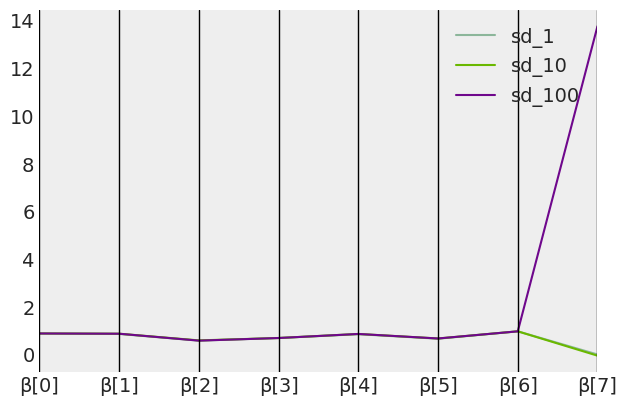

In [96]:
parallel_coordinates(beta_p, "group")

As we increase standard deviation of the beta prior, for the slope parameter, we can see that for most of the groups the effect is neglible. However for group 7 the prior has a strong effect on the posterior estimation because group 7 only has one data point and the unpooled model doesn't consider the datapoints in the other groups. There simple isn't enough data to "wash out" the prior distribution in this case.

# Question 14
***

In [97]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m + eps_real

with pm.Model() as hierarchical_model:
    # hyper-priors
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sd=10)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 10)
    β_μ = pm.Normal('β_μ', mu=0, sd=10)
    β_σ = pm.HalfNormal('β_σ', sd=10)

    # priors
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=M)
    ϵ = pm.HalfCauchy('ϵ', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[idx] + β[idx] * x_centered,
                         sd=ϵ, nu=ν, observed=y_m)

    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    trace_hm = pm.sample(1000)
    ppc_lines = pm.sample_posterior_predictive(trace_hm, samples=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν, ϵ, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:15<00:00, 190.41draws/s]
There were 41 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
100%|██████████| 500/500 [00:00<00:00, 1200.78it/s]


In [100]:
alpha = trace_hm.get_values("α")[369, 1]
beta = trace_hm.get_values("β")[369, 1]

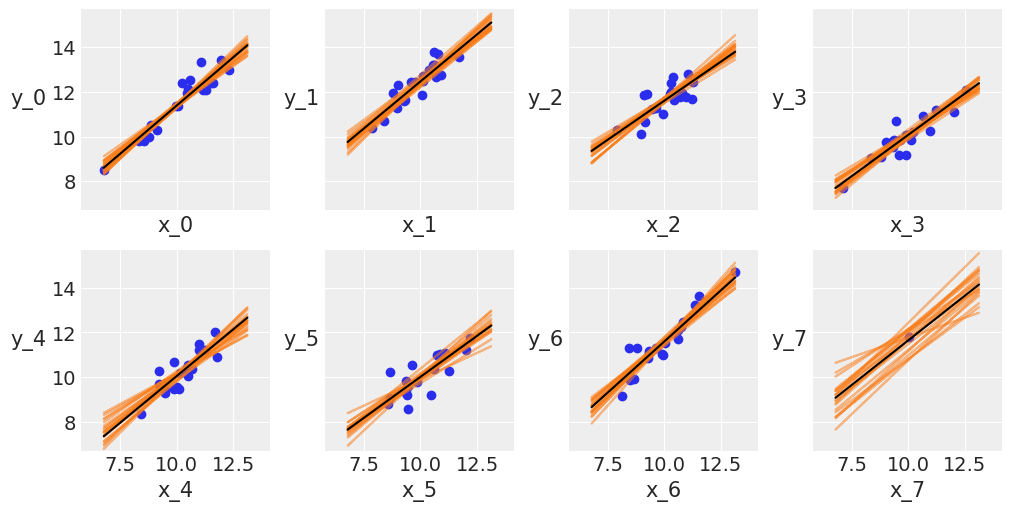

In [103]:
# Get 20 random samples for chain
chain_length =1000
random_draws = np.random.randint(0, chain_length-1, 20)

_, ax = plt.subplots(2, 4, figsize=(10, 5), sharex=True, sharey=True,
                     constrained_layout=True)
ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    
    #We add this one line to plot uncertainty. At least two data points must be present in group
    for random_draw in random_draws:
        alpha = trace_hm.get_values("α")[random_draw, i]
        beta = trace_hm.get_values("β")[random_draw, i]
        ax[i].plot(x_m, alpha + beta*x_m, 'C1-', alpha=0.5)
        # ax[i].plot(x_m, alpha + beta*x_m)

    
    alpha_m = trace_hm['α'][:, i].mean()
    beta_m = trace_hm['β'][:, i].mean()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='k',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

# Question 15
***

In [104]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i, j in zip([10, 2], [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
# X_centered = X - X_mean
y = alpha_real + np.dot(X, beta_real) + eps_real

In [105]:
with pm.Model() as model_mlr:
    α_tmp = pm.Normal('α_tmp', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1, shape=2)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = α_tmp + pm.math.dot(X, β)

    α = pm.Deterministic('α', α_tmp - pm.math.dot(X_mean, β))

    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_mlr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ϵ, β, α_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:24<00:00, 207.02draws/s]
The acceptance probability does not match the target. It is 0.8986859212625729, but should be close to 0.8. Try to increase the number of tuning steps.


In [106]:
az.summary(trace_mlr, var_names=['α', 'β', 'ϵ'])

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
α[0],-10.93,0.91,0.03,-12.61,-9.20,1252.0,1.0
β[0],0.97,0.04,0.00,0.89,1.05,1295.0,1.0
β[1],1.47,0.03,0.00,1.41,1.53,2149.0,1.0
ϵ,0.47,0.03,0.00,0.41,0.54,2600.0,1.0


In the non centered model the alpha parameter changes to compensate for the position of the points. In other words alpha needs to compensate $beta * X$ distance up or down since the x values are not longer centered around the y axis.